In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from typing import List, Dict, Union

In [6]:
import warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

In [7]:
 matches_df = pd.read_parquet("./esta/parsed/matches.parquet")
 rounds_df = pd.read_parquet("./esta/parsed/rounds.parquet")
 kills_df = pd.read_parquet("./esta/parsed/kills.parquet")
 damages_df = pd.read_parquet("./esta/parsed/damages.parquet") 
 grenades_df = pd.read_parquet("./esta/parsed/grenades.parquet") 
 bomb_events_df = pd.read_parquet("./esta/parsed/bomb_events.parquet") 
 weapon_fires_df = pd.read_parquet("./esta/parsed/weapon_fires.parquet") 
 flashes_df = pd.read_parquet("./esta/parsed/flashes.parquet") 
 frames_df = pd.read_parquet("./esta/parsed/frames.parquet")
 players_df = pd.read_parquet("./esta/parsed/players.parquet") 
 team_frames_df = pd.read_parquet("./esta/parsed/team_frames.parquet") 
 player_frames_df = pd.read_parquet("./esta/parsed/player_frames.parquet") 
 inventory_df = pd.read_parquet("./esta/parsed/inventory.parquet") 
 bomb_location_df = pd.read_parquet("./esta/parsed/bomb_location.parquet") 
 projectiles_df = pd.read_parquet("./esta/parsed/projectiles.parquet") 
 smokes_df = pd.read_parquet("./esta/parsed/smokes.parquet") 
 fires_df = pd.read_parquet("./esta/parsed/fires.parquet") 

image_dim = 1024

In [8]:
with open(".awpy/maps/map-data.json", "r") as f:
    all_map_data = json.load(f)


# analysis over single round

In [9]:
selected_map = 'de_mirage'

In [10]:
map_data = all_map_data[selected_map]
selected_matches = matches_df[matches_df.map_name == selected_map]
display(selected_matches.head())
selected_match = selected_matches.iloc[0]
selected_round = 5
sel_idx = (selected_match.match_id,selected_round)

,client_name,map_name,tick_rate,playback_ticks,playback_frames_count,parsed_to_frame_idx,match_id,demo_id,competition_name,hltv_url,match_date,match_name
0,GOTV Demo,de_mirage,127,343251,342767,342784,0839a031-0e2c-4c03-b4bc-b5ba05fe669a,01746483-b3bd-4e4b-a2f2-0de97b17600d,PGL Major Antwerp 2022,https://www.hltv.org/matches/2356160/heroic-vs...,1652781600000,heroic-vs-vitality-pgl-major-antwerp-2022
0,GOTV Demo,de_mirage,127,471790,471564,471581,0a075b4d-576e-46f2-b944-fe9542faee54,04f0fb8f-a4d7-497c-857e-316300fadee3,IEM Katowice 2022,https://www.hltv.org/matches/2354381/furia-vs-...,1645124400000,furia-vs-astralis-iem-katowice-2022
0,GOTV Demo,de_mirage,127,426251,425998,426016,a98ffca7-e968-4a54-9e8f-22f101c2502b,022866a3-090e-42eb-ab8e-aa553a575ada,IEM Katowice 2021,https://www.hltv.org/matches/2346573/faze-vs-f...,1613905200000,faze-vs-furia-iem-katowice-2021
0,GOTV Demo,de_mirage,127,441259,440692,440707,a56115fd-a0ba-4eea-a618-91fd6c57177c,015f7c8d-2bc0-4d83-88e7-60648d2b221c,BLAST Premier Fall Showdown 2021,https://www.hltv.org/matches/2351973/heroic-vs...,1634034600000,heroic-vs-poggerz-blast-premier-fall-showdown-...
0,GOTV Demo,de_mirage,127,493224,492014,492029,f218743d-5e8b-436e-91bd-b7b3664c56c3,0418eb19-853e-4b56-955c-d3eedf2b7e12,BLAST Premier Spring Final 2021,https://www.hltv.org/matches/2349173/natus-vin...,1623853200000,natus-vincere-vs-faze-blast-premier-spring-fin...


## location based analysis over single round

In [11]:
idx_pf_df = player_frames_df.set_index(["match_id","round_num"])
idx_f_df = flashes_df.set_index(["match_id","round_num"])
idx_sm_df = smokes_df.set_index(["match_id","round_num"])
idx_d_df = damages_df.set_index(["match_id","round_num"])
idx_k_df = kills_df.set_index(["match_id","round_num"])
idx_r_df = rounds_df.set_index(["match_id","round_num"])

### transform functions
so data fit the plotting format

In [12]:
def transform_coord(map_data,player_loc,x_col="x",y_col="y"):
    result = player_loc.copy()
        
    pos_x = map_data["pos_x"]
    pos_y = map_data["pos_y"]
    scale = map_data["scale"]

    result[x_col] = (result[x_col] - pos_x) / scale
    result[y_col] = image_dim - (pos_y - result[y_col]) / scale

    return result

#### transform coordinates
to transform for plotting in the map

In [13]:
def transform_coords(map_data,player_loc,status):
    tf = player_loc.copy()
    for st in status:
        tf = transform_coord(map_data,tf,x_col=f"{st}_x",y_col=f"{st}_y")
    return tf

In [14]:
def transform_flash(flashes):
    flashers_cols = [col for col in flashes.columns
                     if not (col.startswith('player_') or col == 'flash_duration')]
    flashers = flashes.loc[:, flashers_cols]
    
    flasheds_cols = [col for col in flashes.columns if not col.startswith('attacker_')]
    flasheds = flashes.loc[:, flasheds_cols]
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
        flashers.loc[:, "status"] = "flasher"
        flasheds.loc[:, "status"] = "flashed"
    
    flashers.columns = [col.replace("attacker_", "") if col != "attacker_side" else col 
                        for col in flashers.columns]
    flasheds.columns = [col.replace("player_", "") if col != "player_side" else col 
                        for col in flasheds.columns]
    
    result = pd.concat([flashers.drop_duplicates(), flasheds.drop_duplicates()])
    result["side"] = result["attacker_side"].fillna(result["player_side"])
    result.sort_values(["tick"],inplace=True)
    
    subset_col = [col for col in result.columns if col not in ["status","flash_duration"]]
    print(subset_col)
    dup_idx = result.duplicated(subset=subset_col)
    keep_idx = result.duplicated(subset=subset_col,keep="last")
    result.loc[dup_idx,"status"] = "both"
    return result.loc[~keep_idx,:]

#### transform action
again, to fit the plotting function and cleaner look, (dim reduce)

In [15]:
def transform_actions(actions: pd.DataFrame, 
                      status: List[str], 
                      status_extra_cols: Dict[str, List[str]] = {},
                      status_code: Dict[str, str] = {},
                      common_extra_cols: List[str] = [],
                      rename_col:Dict[str,str] = {},
                      check_dup_without_cols: List[str] = [],
                      keep: str = "first",
                      assign_dup: dict = {},
                     drop_na_cols: List[str] = []) -> pd.DataFrame:
    """Transforms action data.

    This function processes action data, potentially enriching it with status
    information, handling duplicates, and adding common extra columns.

    Args:
        actions (pd.DataFrame): The action data to transform.
        status (List[str]): Status information to merge with the action data.
        status_extra_cols (Dict[str, List[str]], optional): Extra columns from the
            status data to include in the transformed output. Defaults to {}.
        status_code (Dict[str, str], optional): A mapping to use when
            processing status codes. Defaults to {}.
        common_extra_cols (List[str], optional): A list of extra columns to add
            to the output. Defaults to [].
        check_dup_cols (List[str], optional): Columns to check for duplicates.
            Defaults to [].
        keep (str, optional): How to handle duplicates. See the pandas
            'DataFrame.drop_duplicates' keep parameter. Defaults to "first".
        assign_dup (dict, optional): How to assign values to duplicates.
            Defaults to {}.

    Returns:
        pd.DataFrame: The transformed action data.
    """
    keep_opts = {"first" : "last","last":"first"}
    result = pd.DataFrame()
    for st in status:
        st_cols = []
        extra_cols = status_extra_cols.get(st,[])
        for col in actions.columns:
            if col.startswith(st):
                st_cols.append(col)

            if col in extra_cols:
                st_cols.append(col)

            if col in common_extra_cols:
                st_cols.append(col)
        st_df = actions.loc[:,st_cols]

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
            code = status_code.get(st,None)
            st_df.loc[:, "status"] = code if code is not None else st

        new_cols = []
        for col in st_df.columns:
            if col == f"{st}_side":
                new_cols.append(col)
                continue
            replaced_col = col.replace(f"{st}_","")
            new_cols.append(rename_col.get(replaced_col,replaced_col))
        st_df.columns = new_cols
        # st_df.columns = [col.replace(f"{st}_","") if col != f"{st}_side" else col
        #                 for col in st_df.columns]

        result = pd.concat([result.drop_duplicates(),
                            st_df.drop_duplicates()
                           ])

    side = result[f"{status[0]}_side"]
    for st in status[1:]:
        side = side.fillna(result[f"{st}_side"])
    result["side"] = side
    if check_dup_without_cols is not None and check_dup_without_cols:
        check_dup_cols = [col for col in result.columns if col not in check_dup_without_cols]
        dup_idx = result.duplicated(subset=check_dup_cols,keep=keep_opts[keep])
        keep_idx = result.duplicated(subset=check_dup_cols,keep=keep)
        for key,value in assign_dup.items():
            result.loc[dup_idx,key] = value

        result = result.loc[~keep_idx,:]
        
    return result

### plotting functions

In [16]:
def plot_map(map_name,fig_size,fig=None,ax=None):
    fig,ax = plt.subplots(figsize=fig_size)
    map_img = plt.imread(f".awpy/maps/{map_name}.png")
    ax.imshow(map_img,extent=[0,image_dim,0,image_dim])
    ax.set_xlim(0, image_dim)
    ax.set_ylim(0, image_dim)
    ax.set_title(map_name.title())
    return fig,ax

In [17]:
def count_colorbar(fig):
    result = 0
    for ax in fig.axes:
        if "colorbar" in ax.get_label():
            result += 1
    return result

In [18]:
def plot_loc_unicode(player_loc, 
                     gradient_by, 
                     size,
                     color_by=None,
                     color_dict=None,
                     default_color="viridis",  # Default colormap when color_by is None
                     alpha=0.5,
                     marker_by=None,
                     marker_dict=None,
                     default_marker="o",       # Default marker when marker_by is None
                     fig=None, ax=None):
    if fig is None and ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    selected_col = ["x","y",gradient_by]
    if color_by is not None:
        selected_col.append(color_by)
    if marker_by is not None:
        selected_col.append(marker_by)
    transformed = player_loc.reset_index()[selected_col]
    
    # Create normalization using min and max from the dataframe
    vmin = transformed[gradient_by].min()
    vmax = transformed[gradient_by].max()
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    
    # Process color_by if it exists
    if color_by is not None:
        transformed[color_by] = transformed[color_by].str.lower()
    
    # Define side positions for colorbar
    side = ['left', 'right']
    
    n_colorbar = count_colorbar(fig)
    
    for idx, row in transformed.iterrows():
        if color_by is not None:
            cmap = plt.get_cmap(color_dict[row[color_by]])
        else:
            cmap = plt.get_cmap(default_color)
        
        # Apply normalization
        color_value = norm(row[gradient_by])
        color = cmap(color_value)

        if marker_by is None:
            marker_char = default_marker  # Use default marker
        else:
            marker_char = marker_dict[row[marker_by]]
            
        # Use ax.text for all cases
        ax.text(row["x"], row["y"], marker_char, 
                fontsize=size, color=color, ha='center', va='center',
                alpha=alpha)
        
    ax.set_xlabel("X Coordinate (pixels)")
    ax.set_ylabel("Y Coordinate (pixels)")
    
    # Only create colorbars when color_by is specified
    if color_by is not None:
        for idx, (color_cat, cmap) in enumerate(list(color_dict.items())[:2-n_colorbar]):
            positions = transformed[transformed[color_by] == color_cat]
            dummy_scatter = ax.scatter(positions['x'], positions['y'], 
                                      c=positions[gradient_by], 
                                      cmap=cmap, s=0, alpha=.5,
                                      norm=norm)  # Apply the normalization
            cbar = fig.colorbar(dummy_scatter, ax=ax, location=side[idx], pad=0.02,
                               fraction=0.046, shrink=0.6)
            cbar.set_label(f"{color_cat.upper()} {gradient_by.title()}", fontsize=8)
            cbar.ax.tick_params(labelsize=7)
    
    return fig, ax

In [19]:
def plot_line(actions,status1,status2,
              gradient_by,
              color_by=None,color_dict={},default_color="Greys",
              linewidth=1,alpha=1,
             fig=None,ax=None):
    if fig is None and ax is None:
        fig,ax = plt.subplots(figsize=(10,8))
        
    vmin = actions[gradient_by].min()
    vmax = actions[gradient_by].max()
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    
    for idx,row in actions.iterrows():
        cmap = plt.get_cmap(
            color_dict.get(row[color_by],default_color) if color_by is not None else default_color
        )
        
        color_value = norm(row[gradient_by])
        color = cmap(color_value)
        
        ax.plot([row[f"{status1}_x"],row[f"{status2}_x"]],
                [row[f"{status1}_y"],row[f"{status2}_y"]],
               alpha=alpha,linewidth=linewidth,
               color=color)

    return fig,ax

### test plotting functions with players' location and flashes' location

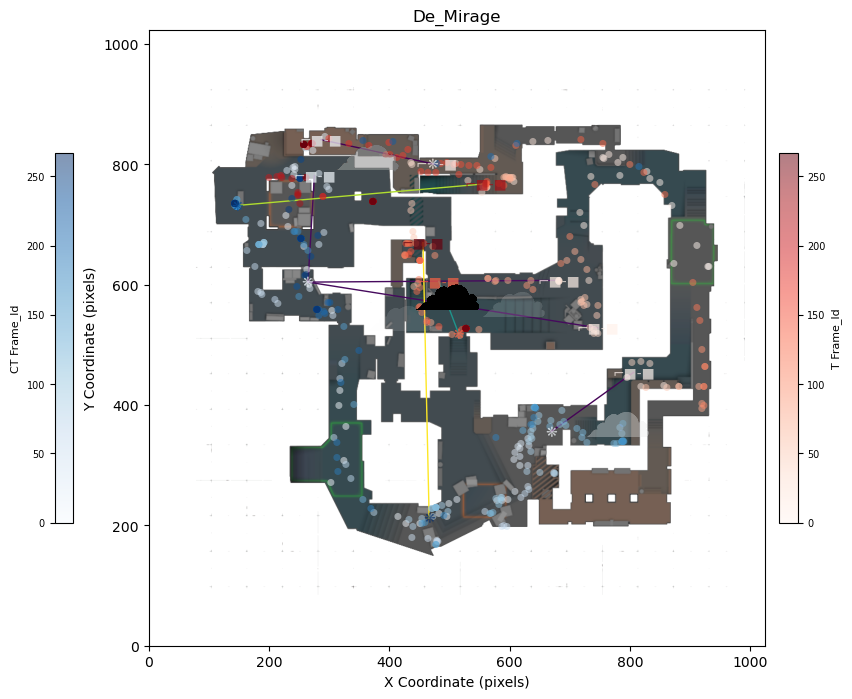

In [20]:

tf_f_co = transform_coords(map_data,
                          idx_f_df.loc[sel_idx],
                         ["attacker","player"])
transformed_flash = transform_actions(tf_f_co,
                 ["attacker","player"],
                 {"player" : ["flash_duration",]},
                 {"attacker" : "flasher","player" : "flashee"},
                  check_dup_without_cols=["status","flash_duration","attacker_side","player_side"],
                  assign_dup={"status":"both"},
                 common_extra_cols = ["tick"],
                 )
transformed_loc = transform_coord(map_data,
                                  idx_pf_df.loc[sel_idx].iloc[::5])

transformed_smoke = transform_coord(map_data,
                                   idx_sm_df.loc[sel_idx])
side_color = {
    "ct" : "Blues",
    "t" : "Reds"
}

flash_marker = {
    "flasher" : "$\u274B$",
    "flashee" : "⌐■-■",
    "both" : "⌐$\u274B$-■"
}
img_fig, img_ax = plot_map(selected_map, (10, 8))

loc_fig, loc_ax = plot_loc_unicode(transformed_loc, 
                                  gradient_by="frame_id", 
                                  size=5,
                                  color_by="side",
                                  color_dict=side_color,
                                  default_marker="$\u2B24$",
                                  fig=img_fig, 
                                  ax=img_ax)

flash_fig, flash_ax = plot_loc_unicode(transformed_flash, 
                                      gradient_by="tick", 
                                      size=10,
                                      color_by="side",
                                      color_dict=side_color,
                                      marker_by="status",
                                      marker_dict=flash_marker,
                                      alpha=0.7,
                                      fig=loc_fig, 
                                      ax=loc_ax)

cf_fig,cf_ax = plot_line(tf_f_co,"attacker","player","tick",default_color="viridis",fig=flash_fig,ax=flash_ax)      
smoke_fig, smoke_ax = plot_loc_unicode(transformed_smoke, 
                                      gradient_by="start_tick", 
                                      size=50,
                                      default_color="Grays",
                                      default_marker='$\u2601$',
                                      alpha=0.02,
                                      fig=cf_fig, 
                                      ax=cf_ax)

plt.show()

## statistical analysis over single round

In [21]:
round_kills = kills_df\
.groupby(["match_id","round_num"]).agg(
    ct_kills=("attacker_side",lambda side : (side == "CT").sum()),
    t_kills=("attacker_side",lambda side : (side == "T").sum()),
    kill_trade_prob = ("is_trade",lambda trade : round(trade.sum()/trade.size,2)),
    kill_assist_prob = ("assister_steam_id",lambda assist : round(assist.notnull().sum()/assist.size,2)),
    kill_flash_prob = ("victim_blinded",lambda blind : round(blind.sum()/blind.size,2)),
    kill_hs_prob = ("is_headshot",lambda hs : (round(hs.sum()/hs.size,2)))
).dropna(how="all")

/tmp/nix-shell.HOUXsE/ipykernel_3477/947949622.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["match_id","round_num"]).agg(


In [22]:
idx_r_df["n_ticks"] = idx_r_df["end_tick"] - idx_r_df["start_tick"]
idx_r_df = idx_r_df[["n_ticks","winning_side","round_end_reason",
                     "ct_round_spend_money","ct_buy_type",
                     "t_round_spend_money","t_buy_type"]]
idx_r_df.head(5)

n_ticks winning_side  \
match_id                             round_num                         
bfa9bbbe-bd16-4713-bd99-745378db05cb 1            11876            T   
                                     2            15789            T   
                                     3            21424            T   
                                     4            46594           CT   
                                     5            13771           CT   

                                               round_end_reason  \
match_id                             round_num                    
bfa9bbbe-bd16-4713-bd99-745378db05cb 1            TerroristsWin   
                                     2             TargetBombed   
                                     3             TargetBombed   
                                     4              TargetSaved   
                                     5                    CTWin   

                                                ct_round_spend_money  \
match_id                             round_num                         
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                          3300   
                                     2                         10200   
                                     3                          1300   
                                     4                         26050   
                                     5                         17350   

                                               ct_buy_type  \
match_id                             round_num               
bfa9bbbe-bd16-4713-bd99-745378db05cb 1            Full Eco   
                                     2            Semi Buy   
                                     3            Semi Eco   
                                     4            Full Buy   
                                     5            Semi Buy   

                                                t_round_spend_money t_buy_type  
match_id                             round_num                                  
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                         3550   Full Eco  
                                     2                        17000   Semi Buy  
                                     3                        11500   Full Buy  
                                     4                        13750   Full Buy  
                                     5                        15200   Full Buy

In [23]:
all_tf_f = transform_actions(idx_f_df,
                 ["attacker","player"],
                 {"player" : ["flash_duration",]},
                 {"attacker" : "flasher","player" : "flashee"},
                  check_dup_without_cols=["status","flash_duration","attacker_side","player_side"],
                  assign_dup={"status":"both"},
                 common_extra_cols = ["tick"],
                 )
round_flashes = all_tf_f.groupby(['match_id', 'round_num']).agg(
    ct_flashers=('attacker_side', lambda x : (x == "CT").sum()),
    t_flashers=('attacker_side', lambda x : (x == "T").sum()),
    ct_flasheds=('player_side', lambda x : (x == "CT").sum()),
    t_flasheds=('player_side', lambda x : (x == "T").sum()),
    avg_flash_duration=("flash_duration","mean")
).dropna(how="all")

round_flashes.head(5)

/tmp/nix-shell.HOUXsE/ipykernel_3477/202441654.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  round_flashes = all_tf_f.groupby(['match_id', 'round_num']).agg(


ct_flashers  t_flashers  \
match_id                             round_num                            
0839a031-0e2c-4c03-b4bc-b5ba05fe669a 1                  0.0         3.0   
                                     2                  2.0         0.0   
                                     3                  1.0         1.0   
                                     4                  3.0         1.0   
                                     5                  4.0         2.0   

                                                ct_flasheds  t_flasheds  \
match_id                             round_num                            
0839a031-0e2c-4c03-b4bc-b5ba05fe669a 1                  4.0         1.0   
                                     2                  3.0         0.0   
                                     3                  1.0         4.0   
                                     4                  2.0         7.0   
                                     5                  2.0         6.0   

                                                avg_flash_duration  
match_id                             round_num                      
0839a031-0e2c-4c03-b4bc-b5ba05fe669a 1                    2.816246  
                                     2                    1.640097  
                                     3                    1.497669  
                                     4                    3.132560  
                                     5                    1.443490

In [ ]:
def get_total_damages(df,col,side,sel_col,damage_col):
    index = col.index.unique()[0]
    cur_df = df.loc[index]
    return cur_df[cur_df[sel_col]==side][damage_col].sum()


all_damages = transform_actions(idx_d_df,
                 ["attacker","victim"],
                 status_extra_cols={
                     "attacker" : ["hp_damage","armor_damage","zoom_level"],
                     "victim" : ["hp_damage_taken","armor_damage_taken"],
                 },
                 common_extra_cols=["tick","hit_group","is_friendly_fire","distance"],
                # rename_col={"hp_damage_taken":"hp_damage","armor_damage_taken":"armor_damage"}
                 )
all_damages["total_damage_done"] = all_damages["hp_damage"] + all_damages["armor_damage"]
all_damages["total_damage_taken"] = all_damages["hp_damage_taken"] + all_damages["armor_damage_taken"]

round_damages = all_damages.groupby(["match_id","round_num"]).agg(
    ct_damages_done = ("total_damage_done", lambda x : get_total_damages(all_damages,x,"CT","attacker_side","total_damage_done")),
    t_damages_done = ("total_damage_done", lambda x : get_total_damages(all_damages,x,"T","attacker_side","total_damage_done")),
    ct_damages_recieve = ("total_damage_taken",lambda x : get_total_damages(all_damages,x,"CT","victim_side","total_damage_taken")),
    t_damages_recieve = ("total_damage_taken",lambda x : get_total_damages(all_damages,x,"T","victim_side","total_damage_taken")),
    
).dropna(how="all")
round_damages.head(5)

/tmp/nix-shell.HOUXsE/ipykernel_3477/4006305192.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  round_damages = all_damages.groupby(["match_id","round_num"]).agg(


In [26]:
pd.concat([idx_r_df,round_kills,round_flashes,round_damages],axis=1)

n_ticks winning_side  \
match_id                             round_num                         
bfa9bbbe-bd16-4713-bd99-745378db05cb 1            11876            T   
                                     2            15789            T   
                                     3            21424            T   
                                     4            46594           CT   
                                     5            13771           CT   
...                                                 ...          ...   
816e1612-9d2e-4893-af23-bda90c479598 13            8828           CT   
                                     14           13412           CT   
                                     15           10620           CT   
                                     16           45289           CT   
                                     17           15284            T   

                                               round_end_reason  \
match_id                             round_num                    
bfa9bbbe-bd16-4713-bd99-745378db05cb 1            TerroristsWin   
                                     2             TargetBombed   
                                     3             TargetBombed   
                                     4              TargetSaved   
                                     5                    CTWin   
...                                                         ...   
816e1612-9d2e-4893-af23-bda90c479598 13                   CTWin   
                                     14                   CTWin   
                                     15                   CTWin   
                                     16             BombDefused   
                                     17           TerroristsWin   

                                                ct_round_spend_money  \
match_id                             round_num                         
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                          3300   
                                     2                         10200   
                                     3                          1300   
                                     4                         26050   
                                     5                         17350   
...                                                              ...   
816e1612-9d2e-4893-af23-bda90c479598 13                        22350   
                                     14                         9000   
                                     15                        12450   
                                     16                         3350   
                                     17                        19450   

                                               ct_buy_type  \
match_id                             round_num               
bfa9bbbe-bd16-4713-bd99-745378db05cb 1            Full Eco   
                                     2            Semi Buy   
                                     3            Semi Eco   
                                     4            Full Buy   
                                     5            Semi Buy   
...                                                    ...   
816e1612-9d2e-4893-af23-bda90c479598 13           Full Buy   
                                     14           Full Buy   
                                     15           Full Buy   
                                     16           Full Eco   
                                     17           Semi Buy   

                                                t_round_spend_money  \
match_id                             round_num                        
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                         3550   
                                     2                        17000   
                                     3                        11500   
                                     4                        13750   
                                     5                        15200  

In [37]:
all_damages["total_damage_done"][all_damages["side"]=="CT"].sum()

753342.0